In [1]:
from common import *

base_dir = "/home/wanxinli/deep_patient"
data_dir = "outputs/synthetic/complicated"

/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
""" 
Simulation mechinism
"""

def simulate():

    """ 
    Simulate female and male datasets as follows:
    - (integer) medical code range: [0, 19]
    - both female and male datasets shape are of [1000, 10], 1000 samples with 10 medical codes
    - [0, 4] are in males while [5, 9] are more prevalent (90%) in females (consider masking)
    - other codes are of equal probablities
    - y (label) is 1 if three of [0, 4] or three of [5, 9] are present
    """

    def gen_labels(seqs, sex):

        """ 
        Generate labels based on the representations (reps)
        The label is 1 if three of [0, 4] for male or [5, 9] for female are present

        :param seqs: male sequenesces or female sequences
        :param sex: male or female
        """

        labels = []
        key_codes = []
        if sex == "male":
            key_codes = list(range(0, 5))
        elif sex == "female":
            key_codes = list(range(5, 10))
        else:
            raise Exception("invalid sex")

        for seq in seqs:
            seq = np.sort(seq)
            key_exist_codes = np.intersect1d(seq, key_codes)
            if len(key_exist_codes) >= 3: # more than two of the key codes exist
                labels.append(1)
            else:
                labels.append(0)
        return np.array(labels)
 

    n_features = 10
    n_samples = 1000
    vocab = list(range(0, 20))

    # simulate male data
    male_vocab_probs = [9,9,9,9,9,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5]
    male_vocab_probs = [elem/sum(male_vocab_probs) for elem in male_vocab_probs]
    male_seqs = []
    for i in range(n_samples):
        male_seqs.append(np.random.choice(vocab, n_features, p=male_vocab_probs))
    male_labels = gen_labels(male_seqs, "male")

    # simulate female data
    female_vocab_probs = [1,1,1,1,1,9,9,9,9,9,5,5,5,5,5,5,5,5,5,5]
    female_vocab_probs = [elem/sum(female_vocab_probs) for elem in female_vocab_probs]
    female_seqs = []
    for i in range(n_samples):
        female_seqs.append(np.random.choice(vocab, n_features, p=female_vocab_probs))
    female_labels = gen_labels(female_seqs, "female")
    
    return np.array(male_seqs), male_labels, np.array(female_seqs), female_labels
    

In [3]:
"""
Train deep patient model and generate representations for males and females
"""

def custom_train_reps(male_seqs, female_seqs):
    """ 
    Customized training algorithm for generating male representations and female representations
    
    :returns: male representations, female representations
    """

    # customized parameters
    nhidden = 5
    nlayer = 1

    # for males
    # initiate the model
    male_sda = SDA(male_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 10,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    male_sda.train(male_seqs)

    # apply the mode
    male_reps = male_sda.apply(male_seqs)

    # for females
    # initiate the model
    female_sda = SDA(female_seqs.shape[1],
                nhidden=nhidden,
                nlayer=nlayer,
                param={
        'epochs': 10,
        'batch_size': 5,
        'corrupt_lvl': 0.05
    })

    # train the model
    female_sda.train(female_seqs)

    # apply the mode
    female_reps = female_sda.apply(female_seqs)
    return male_reps, female_reps


In [4]:
""" 
Run the entire procedure multiple times
"""

male_precisions, male_recalls, female_precisions, female_recalls, \
        trans_female_precisions, trans_female_recalls = \
            run_proc_multi(simulate, custom_train_reps)

initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 10
(*) no. of hidden units: 5
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 10

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 6.254
(*) epoch 2, cost 5.882
(*) training time: 0.03 sec.

training time: 1.38 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 10
(*) no. of hidden units: 5
(*) data corruption level: 0.05
(*) learning rate: 0.10
(*) batch size: 5
(*) no. of epochs: 10

training: 1-layer SDAs

training: DA [layer: 1]
(*) preprocessing: normalize features
(*) epoch 1, cost 6.698
(*) epoch 2, cost 6.500
(*) training time: 0.03 sec.

training time: 0.28 sec.

applying: 1-layer SDA
(*) applying: DA [layer: 1]
initializing: 1-layer SDAs

initialized: DA [layer: 1]
(*) no. of visible units: 10
(*) no. of hidden un

In [5]:
save_scores(male_precisions, male_recalls, female_precisions, female_recalls, \
    trans_female_precisions, trans_female_recalls, os.path.join(base_dir, data_dir))

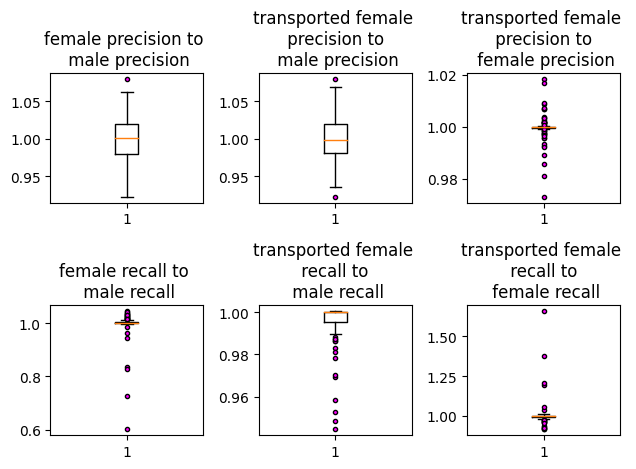

In [2]:
""" 
Box plot of the precision and recalls 
"""
box_plot(os.path.join(base_dir, data_dir, "scores.csv"))